In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
from statistics import mean, stdev
import geh as ga

In [3]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [4]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [8]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6              # No of loop detectors
n_seq = 3                    # Subsequences
n_steps = 5                  # time-step per subsequence
val_percent = 0.2        # 2 weeks
batch_size = 32

#### 5 mins

In [9]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [10]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [11]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [12]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [13]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [14]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [15]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [16]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [17]:
# define no_of_channels
n_channels = 1

In [18]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [19]:
Xv5.shape

(4017, 3, 5, 6, 1)

# CNN-LSTM model

In [20]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [21]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [22]:
def build_model_5(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_5)
    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(LSTM_5)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_5

In [23]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7bi-CNN-LSTM-5",
)

In [24]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 30 Complete [00h 08m 15s]
val_loss: 0.0022792042000219226

Best val_loss So Far: 0.002258074819110334
Total elapsed time: 04h 59m 16s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\7bi-CNN-LSTM-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 192
kernel_size: 3
units_LSTM: 92
learning_rate: 0.001
Score: 0.002258074819110334


### Best Model

In [27]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [28]:
scaler_filename = "Best_HP/7bi-ConvLSTM-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/7bi-ConvLSTM-5']

In [29]:
model5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DeepInput (InputLayer)      [(None, None, 5, 6, 1)]   0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3, 4, 192)  1920      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 2304)       0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 92)                882096    
                                                                 
 output (Dense)              (None, 6)                 558       
                                                                 
Total params: 884,574
Trainable params: 884,574
Non-trainab

In [30]:
model5.fit((Xt5), yt5, 
           epochs = 100, 
           verbose = 0)

In [31]:
model5.save("my_dir/7bi-CNN-LSTM-5")

INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-5\assets


INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-5\assets


In [32]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

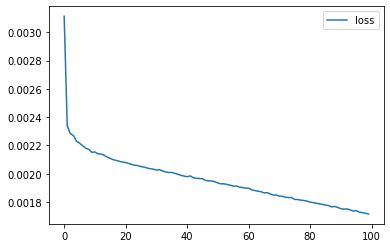

In [33]:
metrics5[['loss']].plot()

In [22]:
model5 = keras.models.load_model("my_dir/7bi-CNN-LSTM-5") 

In [28]:
scaler.inverse_transform(model5.predict(Xv5))

array([[ 31.12337  ,  20.357141 ,  30.640772 ,  77.73412  ,  29.36467  ,
          6.2987943],
       [ 30.657495 ,  19.753977 ,  28.224669 ,  79.588135 ,  32.29215  ,
          2.7916143],
       [ 29.714214 ,  16.017405 ,  26.473202 ,  72.95587  ,  29.726835 ,
          5.255946 ],
       ...,
       [ 42.855843 ,  37.416096 ,  44.177956 ,  91.09347  ,  44.775    ,
         14.1298895],
       [ 42.35477  ,  39.41987  ,  48.09487  , 102.57359  ,  47.29436  ,
         12.15839  ],
       [ 40.7576   ,  38.315117 ,  46.7777   , 101.0978   ,  43.92512  ,
         13.879064 ]], dtype=float32)

# 15 mins ahead

In [38]:
def build_model_15(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_15)
        
    # Output
    output = keras.layers.Dense(n_features, name= "output")(LSTM_15)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [39]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7bi-CNN-LSTM-15",
)

In [40]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [41]:
tuner15.search((Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 30 Complete [00h 03m 50s]
val_loss: 0.00321352481842041

Best val_loss So Far: 0.0027068881317973137
Total elapsed time: 04h 56m 08s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [42]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\7bi-CNN-LSTM-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 512
kernel_size: 3
units_LSTM: 97
learning_rate: 0.001
Score: 0.0027068881317973137


### Best model

In [43]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [44]:
scaler_filename = "Best_HP/7bi-ConvLSTM-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/7bi-ConvLSTM-15']

In [45]:
model15.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DeepInput (InputLayer)      [(None, None, 5, 6, 1)]   0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3, 4, 512)  5120      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 6144)       0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 97)                2421896   
                                                                 
 output (Dense)              (None, 6)                 588       
                                                                 
Total params: 2,427,604
Trainable params: 2,427,604
Non-tra

In [46]:
model15.fit((Xt15), yt15, 
            epochs = 100, 
            verbose = 0)

In [47]:
model15.save("my_dir/7bi-ConvLSTM-15")

INFO:tensorflow:Assets written to: my_dir/7bi-ConvLSTM-15\assets


INFO:tensorflow:Assets written to: my_dir/7bi-ConvLSTM-15\assets


In [48]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

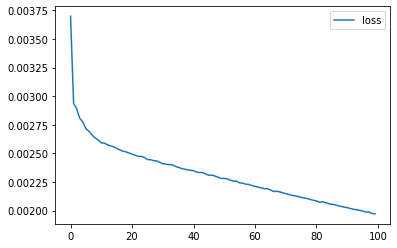

In [49]:
metrics15[['loss']].plot()

In [25]:
model15 = keras.models.load_model("my_dir/7bi-ConvLSTM-15")

In [26]:
scaler.inverse_transform(model15.predict(Xv15))

array([[ 31.377752,  22.674597,  23.015648,  72.25046 ,  33.058758,
          7.291235],
       [ 30.600098,  23.15506 ,  24.427528,  73.489136,  33.727528,
          8.417073],
       [ 29.606285,  21.138056,  22.213272,  69.61091 ,  32.925407,
          8.074766],
       ...,
       [ 45.380615,  45.63246 ,  56.86636 , 110.49737 ,  50.650696,
         16.392313],
       [ 43.082794,  41.178223,  52.452736, 105.51314 ,  50.618713,
         22.381775],
       [ 40.205505,  38.506935,  50.617966, 100.223236,  49.161026,
         19.285198]], dtype=float32)

# 30 mins ahead

In [29]:
def build_model_30(hp):
    # Input
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_30)
    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(LSTM_30)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [30]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7bi-CNN-LSTM-30",
)

In [31]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [33]:
tuner30.search((Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 31 Complete [00h 04m 29s]
val_loss: 540.6017150878906

Best val_loss So Far: 533.4771118164062
Total elapsed time: 09h 12m 23s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\7bi-CNN-LSTM-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 128
kernel_size: 2
units_LSTM: 80
learning_rate: 0.001
Score: 533.4771118164062


### Best model

In [35]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [36]:
scaler_filename = "7bi-ConvLSTM-30"
joblib.dump(best_hp30, scaler_filename) 

['7bi-ConvLSTM-30']

In [37]:
model30.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DeepInput (InputLayer)      [(None, None, 5, 6, 1)]   0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 4, 5, 128)  640       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 2560)       0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 80)                845120    
                                                                 
 output (Dense)              (None, 6)                 486       
                                                                 
Total params: 846,246
Trainable params: 846,246
Non-trainab

In [38]:
model30.fit(Xt30, yt30, 
            epochs = 100, 
            verbose = 0)

In [39]:
model30.save("my_dir/7bi-CNN-LSTM-30")

INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-30\assets


INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-30\assets


In [40]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

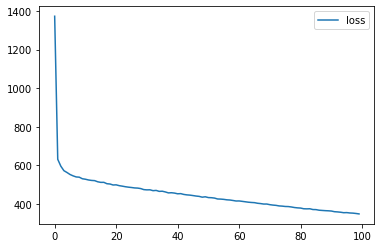

In [41]:
metrics30[['loss']].plot()

In [42]:
model30 = keras.models.load_model("my_dir/7bi-CNN-LSTM-30")

In [43]:
model30.predict(Xv30)

array([[ 28.747562 ,  16.62747  ,  19.5181   ,  65.79873  ,  27.798498 ,
         -1.625243 ],
       [ 27.971153 ,  15.144012 ,  24.711742 ,  71.559105 ,  29.911772 ,
          1.4340127],
       [ 26.301022 ,  13.654028 ,  22.885565 ,  66.75925  ,  29.683739 ,
          0.9553082],
       ...,
       [ 39.220596 ,  37.9893   ,  53.06701  , 109.40951  ,  52.43554  ,
          1.2395146],
       [ 39.006393 ,  37.607635 ,  46.402412 , 108.24572  ,  52.7803   ,
          3.3178647],
       [ 42.714993 ,  39.310486 ,  45.747612 , 106.00635  ,  52.111893 ,
          7.3709545]], dtype=float32)

# 60 mins ahead

In [46]:
def build_model_60(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_60)
    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(LSTM_60)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [47]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7bi-CNN-LSTM-60",
)

In [48]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
tuner60.search((Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 30 Complete [00h 08m 31s]
val_loss: 683.0435485839844

Best val_loss So Far: 664.0774230957031
Total elapsed time: 06h 07m 06s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [50]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\7bi-CNN-LSTM-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 512
kernel_size: 3
units_LSTM: 87
learning_rate: 0.0001
Score: 664.0774230957031


### Best model

In [51]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [52]:
scaler_filename = "Best_HP/7b-ConvLSTM-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/7b-ConvLSTM-60']

In [53]:
model60.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DeepInput (InputLayer)      [(None, None, 5, 6, 1)]   0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3, 4, 512)  5120      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 6144)       0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 87)                2168736   
                                                                 
 output (Dense)              (None, 6)                 528       
                                                                 
Total params: 2,174,384
Trainable params: 2,174,384
Non-tra

In [54]:
model60.fit(Xt60, yt60, 
            epochs = 100, 
            verbose = 0
            )

In [55]:
model60.save("my_dir/7bi-CNN-LSTM-60")

INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-60\assets


INFO:tensorflow:Assets written to: my_dir/7bi-CNN-LSTM-60\assets


In [56]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

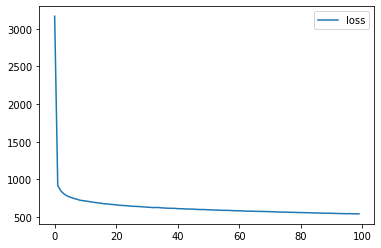

In [57]:
metrics60[['loss']].plot()

In [58]:
model60 = keras.models.load_model("my_dir/7bi-CNN-LSTM-60")

In [59]:
model60.predict(Xv60)

array([[ 32.427    ,  18.949146 ,  20.787207 ,  63.811527 ,  30.994316 ,
          6.3326483],
       [ 30.44577  ,  15.920682 ,  20.189505 ,  62.432747 ,  31.026293 ,
          6.7645307],
       [ 31.286318 ,  16.009317 ,  19.275717 ,  61.58096  ,  30.323803 ,
          6.2033367],
       ...,
       [ 42.139874 ,  39.73237  ,  47.323776 , 114.932625 ,  50.760162 ,
         20.047783 ],
       [ 40.545864 ,  39.29258  ,  47.469624 , 118.50063  ,  51.87365  ,
         18.802507 ],
       [ 38.03823  ,  35.714363 ,  39.695007 , 108.80077  ,  50.311752 ,
         15.541085 ]], dtype=float32)